In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility imports
from utilities.processing_utility import get_q_2_cw_data 
from utilities.processing_utility import get_train_test_split, get_moving_average


In [2]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'S&P 500 adjusted closing price')

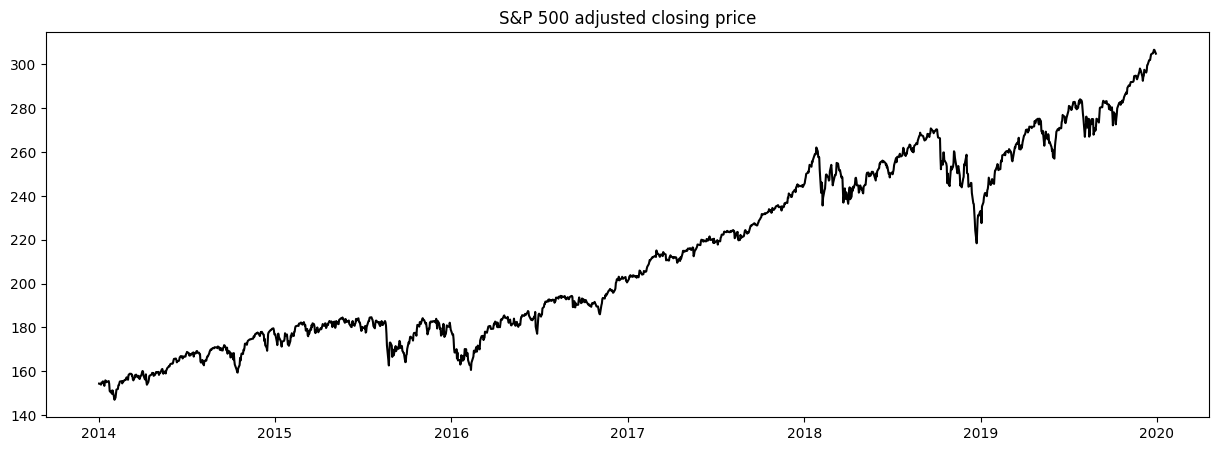

In [13]:
# plot S&P 500
plt.plot(df['adjusted_close_price'], color='black')
plt.title('S&P 500 adjusted closing price')

Text(0.5, 1.0, 'Normalised Excess Returns')

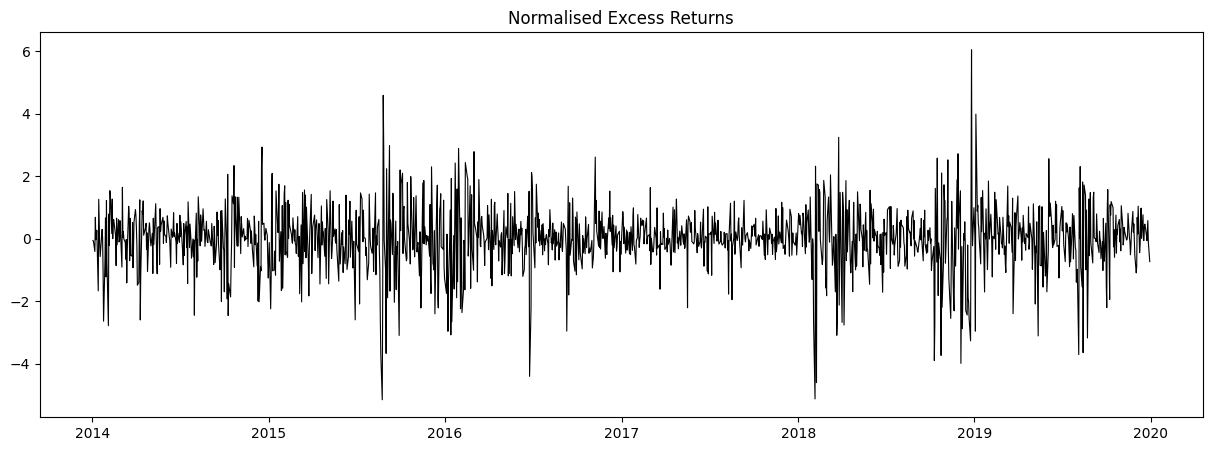

In [10]:
# plot normalised excess returns
plt.plot(df['normalised_excess_returns'], color = 'black', lw = 0.8, alpha = 1)
plt.title('Normalised Excess Returns')

In [5]:
bb_data = get_moving_average(df['normalised_excess_returns'], 20, True)

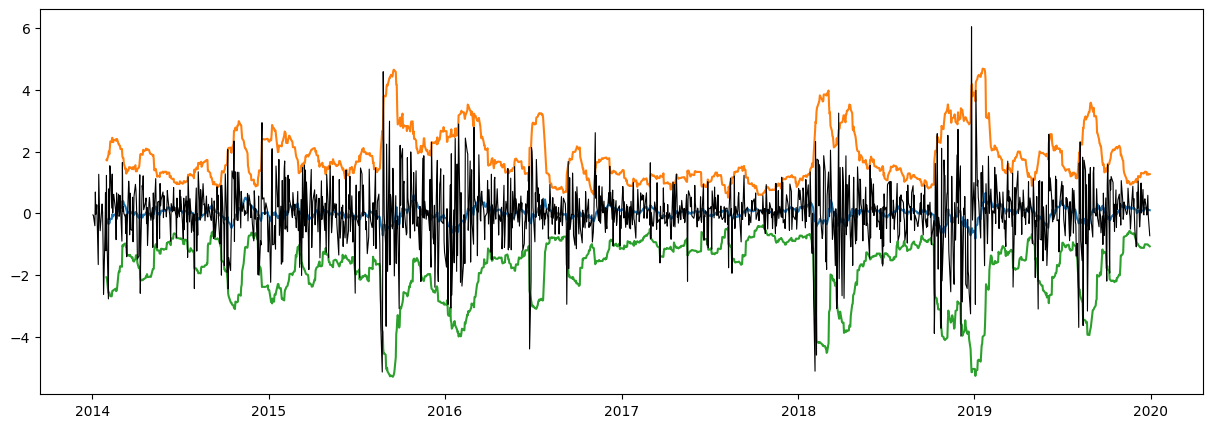

In [7]:
plt.plot(bb_data)
plt.plot(df['normalised_excess_returns'], color = 'black', lw = 0.8)